# AB Testing Example

We use [this](https://www.kaggle.com/osuolaleemmanuel/ad-ab-testing) AB test Ads data set to run a mock AB test. In this notebook we run through:
1. Experiment design of an AB test
2. Analysing the results of an AB test
3. Exploring bias in AB test results
4. Statistical significance

In [1]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(123)
plt.style.use('ggplot')

## Calculate sample size

Assuming the effect sizes below, and a statistical power of 80%.

The effect size is calculated using [Cohen's h](https://en.wikipedia.org/wiki/Cohen%27s_h). This is a small effect size, meaning we'll need more samples. Our base success rate under null hypothesis is ~0.07. We want to detect a success rate of 0.1.

In [2]:
# Cohen's h
effect = sms.proportion_effectsize(0.1, 0.07)
effect

0.10797445447889653

In [3]:
should_sample = sms.tt_ind_solve_power(
    effect_size=effect, # effect size
    power=0.8, # statistical power
    alpha=0.05, # significance level
)
np.round(should_sample).astype(int)

1347

Below we can see that ~1400 samples gives us a statistical power of 80%. This is the probability that the test correctly rejects the null hypothesis when a specific alternative hypothesis is true, i.e. if there is an effect we have an 80% chance of a true positive and a 20% chance of making a Type 2 error.

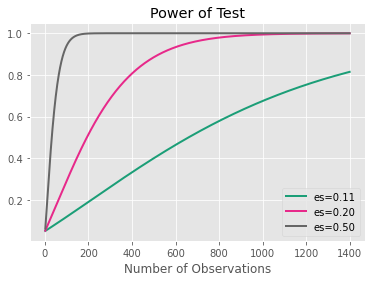

In [4]:
# Varying sample and effect size
power_plot = sms.TTestIndPower().plot_power(
    dep_var='nobs',
    nobs=np.arange(2, 1400),
    effect_size=[effect, 0.2, 0.5],
)

## Grab the data

Here we will use [this](https://www.kaggle.com/osuolaleemmanuel/ad-ab-testing) data set, and pretend we have just randomly selected these users (given by their unique `auction_id` identifier).

The data contains the following columns:
- `auction_id`: unique id of user
- `device_make`: device make of the user
- `platform_os`: OS of the user
- `browser`: browser of the user

In [5]:
df = pd.read_csv("data/data.csv",index_col=[0])
df.drop(columns=["conversion", "date"]).head()

,auction_id,device_make,platform_os,browser
0,0008ef63,Generic Smartphone,6,Chrome Mobile
1,000eabc5,Generic Smartphone,6,Chrome Mobile
2,0016d14a,E5823,6,Chrome Mobile WebView
3,00187412,Samsung SM-A705FN,6,Facebook
4,001a7785,Generic Smartphone,6,Chrome Mobile


In [6]:
# Each user is unique and logged into the platform once
len(set(df.auction_id)) == len(df)

True

In [7]:
# We assign each user to a control group (0) or a treatment group (1) randomly
df['group'] = np.round(np.random.rand(len(df))).astype(int)
df.drop(columns=["conversion", "date"]).head()

,auction_id,device_make,platform_os,browser,group
0,0008ef63,Generic Smartphone,6,Chrome Mobile,1
1,000eabc5,Generic Smartphone,6,Chrome Mobile,0
2,0016d14a,E5823,6,Chrome Mobile WebView,0
3,00187412,Samsung SM-A705FN,6,Facebook,1
4,001a7785,Generic Smartphone,6,Chrome Mobile,1


In [ ]:
df.to_csv("data/test.csv")

## "Run" the AB test

We simulate the performance of an A/B test, with a control group of no new payment method and a test group introduced to a new payment method. The null hypothesis is that the new payment method does not affect conversion. There are several points to consider in this test:

- We perform a randomised control trial. This means any incremental impact we may see in the test group is not due to population attributes.
- The population sizes have been chosen based on the statistical power of the test. For example, an N that in 80% of tests will produce a 95% confidence interval in our metric.
- Our metric should have a time limit. The limit applied in the data set is 1 week.
- We want to choose our hypothesised incremental change to conversion, within this period, for our statistical power and N size. In reality we can choose several incremental changes to investigate.
- We need to compute a test statistic and p-value using our samples to ensure our incremental change is statistically significant.


Our example treatment is that we introduced a new payment method to the treatment group. Our null hypothesis is that a new payment system will not increase conversion. Our AB test ran for 1 week, with `conversion` as our metric i.e. was a payment made. We assume `date` is when they logged on. In this case all users in the experiment logged on. 

In [8]:
df = pd.read_csv("data/test.csv", index_col=[0])

In [9]:
min(df.date), max(df.date)

('2020-07-03', '2020-07-10')

In [10]:
# AB test ran for 1 week, conversion is our metric
df.head()

,auction_id,date,device_make,platform_os,browser,conversion,group
0,0008ef63,2020-07-10,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5,2020-07-07,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a,2020-07-05,E5823,6,Chrome Mobile WebView,0,1
3,00187412,2020-07-03,Samsung SM-A705FN,6,Facebook,0,1
4,001a7785,2020-07-03,Generic Smartphone,6,Chrome Mobile,0,1


## Exploring the groups

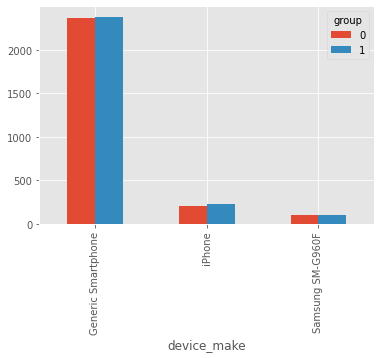

In [11]:
df.groupby("group").device_make.value_counts().nlargest(6).unstack(0).plot(kind="bar")

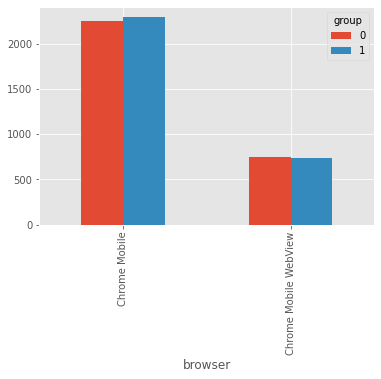

In [12]:
df.groupby("group").browser.value_counts().nlargest(4).unstack(0).plot(kind="bar")

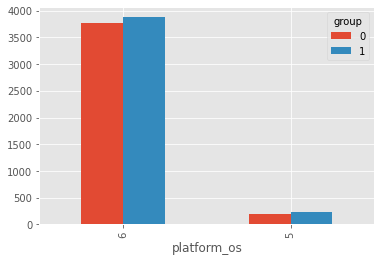

In [13]:
df.groupby("group").platform_os.value_counts().nlargest(4).unstack(0).plot(kind="bar")

## Let's look at conversion

In [14]:
df.groupby("group").conversion.agg(["size", "mean", np.std])

,size,mean,std
group,,,
0,3978,0.067371,0.250694
1,4099,0.074164,0.262070


In [15]:
print("Percentage that were not converted:")
100 * (1 - df.groupby("group").conversion.mean())

Percentage that were not converted:


group
0    93.262946
1    92.583557
Name: conversion, dtype: float64

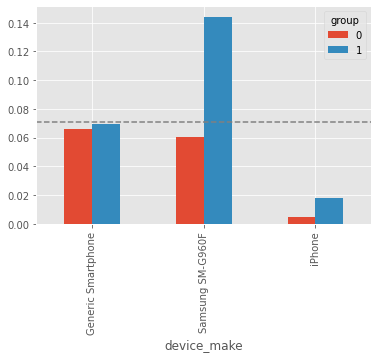

In [16]:
popular_device_make = df.device_make.value_counts().nlargest(3).index

fig, ax = plt.subplots()
df.query("device_make in @popular_device_make").groupby(["group","device_make"]).conversion.mean().unstack("group").plot(kind="bar", ax=ax)
ax.axhline(y=df.conversion.mean(), color='gray', linestyle='--')

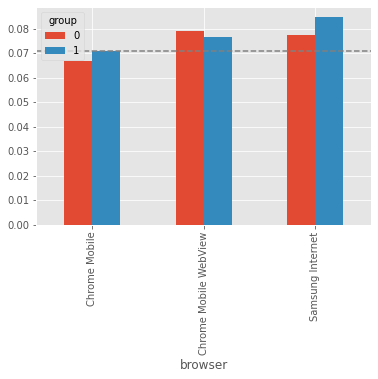

In [17]:
popular_browser = df.browser.value_counts().nlargest(3).index

fig, ax = plt.subplots()
df.query("browser in @popular_browser").groupby(["group","browser"]).conversion.mean().unstack("group").plot(kind="bar", ax=ax)
ax.axhline(y=df.conversion.mean(), color='gray', linestyle='--')

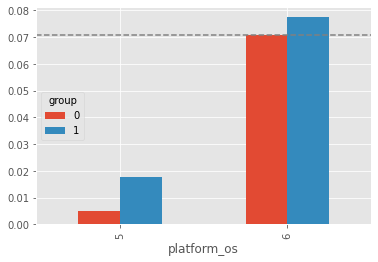

In [18]:
popular_platform_os = df.platform_os.value_counts().nlargest(2).index

fig, ax = plt.subplots()
df.query("platform_os in @popular_platform_os").groupby(["group","platform_os"]).conversion.mean().unstack("group").plot(kind="bar", ax=ax)
ax.axhline(y=df.conversion.mean(), color='gray', linestyle='--')

Here we want to see if there is any link between conversion and the `device_make`, `platform_os`, and `browser`. As we randomly sampled our data we do not expect there to be any correlation. We can see there is on average more conversion for the Samsung device, Samsung Internet browser and OS 6.

In the charts below we plot 95% confidence intervals, which shows predominantly overlapping intervals, the differences in these categories between converted/unconverted are therefore not statistically significant. The one excpetion being the iPhone `device_make`, which affects a small percentage of data. We could regress out this bias with a Logistic regression model.

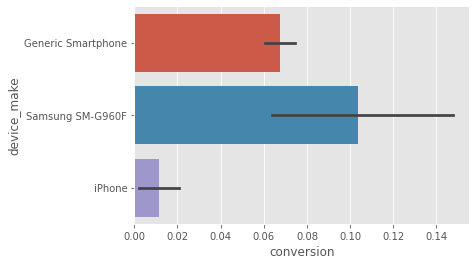

In [19]:
sns.barplot(data=df.query("device_make in @popular_device_make"), x="conversion", y="device_make")

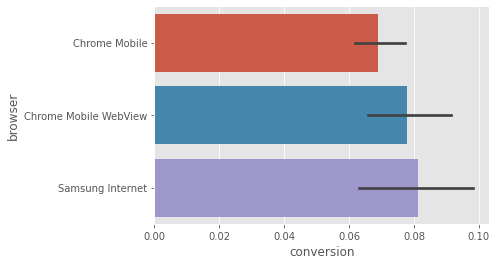

In [20]:
sns.barplot(data=df.query("browser in @popular_browser"), x="conversion", y="browser")

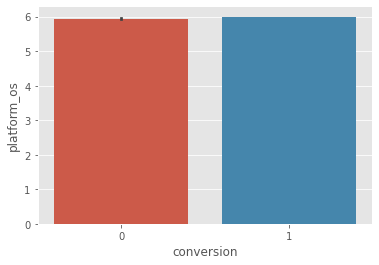

In [21]:
sns.barplot(data=df.query("platform_os in @popular_platform_os"), x="conversion", y="platform_os")

## Exploring statistical significance of our treatment

We can see that our user attributes, `device_make`, `platform_os`, and `browser`, are not biasing our test. Now, we focus on rejecting or failing to reject our null hypothesis, that a new payment system will not increase conversion.

We can calculate the p value to do this, looking for a p value below our significance level of 0.5, i.e. 1 in 20 times we would get a value at least that large given the null hypothesis is true.

In [22]:
df.groupby("group").conversion.agg(["size", "mean", np.std])

,size,mean,std
group,,,
0,3978,0.067371,0.250694
1,4099,0.074164,0.262070


In [23]:
groups = df.groupby("group").conversion.mean()
inc_val = 100 * groups.diff().iloc[1] / groups.iloc[0]
print(f"The incremental value of introducing a new payment method is {inc_val:.2f}%.")

The incremental value of introducing a new payment method is 10.08%.


In [24]:
df.groupby("group").conversion.mean()

group
0    0.067371
1    0.074164
Name: conversion, dtype: float64

Our new payment method performed slightly better than our current method, but is it statistically significant?

In [25]:
t_stat, p_val = stats.ttest_ind(df.query("group == 0").conversion, df.query("group == 1").conversion)
p_val

0.2341039627272198

As our p value is above our significance level of 0.05, therefore we fail to reject the null hypothesis.

Introducing a new payment method may have improved conversion, however we cannot rule out that this was just due to chance. We would therefore need to repeat the experiment to gain more data and insights, or revise the payment method.